# TEXTUAL DATA ANALYSIS EXERCISE 3 - Translation mining

## Preface

In this exercise you will test comparing two texts:

1. The Finnish translation of the Adventures of Huckleberry Finn (the whole book)
2. A small section of the English original

In the exercise you should convince yourself that the cross-lingual embedding models can indeed identify the area where the texts match. You can do so by splitting the texts into small overlapping segments, embedding each using a cross-lingual model, comparing the embeddings all against all with cosine similarity, and plotting the results as a heatmap. When splitting the texts, a 2000-character long sliding window with stride of 500 characters worked for me, so you can use that as a reasonable default. The result should look something like the image below. You can clearly see the line where the English text matches the Finnish text. Your job is to replicate this result. :)

For this to work, I suggest you use the model named paraphrase-xlm-r-multilingual-v1 in the Sentence Transformer library. Most likely you will want to use GPU, but do protect your Colab quota and debug your code on a small sample using CPU while developing, and only switch to GPU when ready to run the whole thing.

The English text: https://www.gutenberg.org/ebooks/7104.txt.utf-8

The Finnish text: https://www.gutenberg.org/ebooks/47095.txt.utf-8

The result should end up looking something like this (give or take colors, ranges, etc which might differ for you. You recognize a correct solution by a clear, long line.

## Setup

In [2]:
!wget https://www.gutenberg.org/ebooks/7104.txt.utf-8
!wget https://www.gutenberg.org/ebooks/47095.txt.utf-8

--2025-01-23 07:42:46--  https://www.gutenberg.org/ebooks/7104.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/7104/pg7104.txt [following]
--2025-01-23 07:42:48--  http://www.gutenberg.org/cache/epub/7104/pg7104.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/7104/pg7104.txt [following]
--2025-01-23 07:42:48--  https://www.gutenberg.org/cache/epub/7104/pg7104.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90206 (88K) [text/plain]
Saving to: ‘7104.txt.utf-8’

7104.txt.utf-8      100%[===================>]  88.09K   138KB

In [3]:
!mv 7104.txt.utf-8 english.txt.utf-8
!mv 47095.txt.utf-8 finnish.txt.utf-8

## Algos

In [4]:
def reader(text_file: str) -> str:
  with open(text_file, 'r') as f:
    lines = f.readlines()
    content = ''.join(lines)
  return content

In [5]:
def splitter(text_str: str, win_size: int, win_stride: int) -> list:
  text_list = list()
  for i in range(0, len(text_str), win_stride):
    text_list.append(text_str[i:i+win_size])
  return text_list


In [6]:
def checker(text_list: list) -> None:
  counter = 1
  for t in text_list[-10:]:
    print(f'part {counter} with length = {len(t)}')
    counter += 1

In [7]:
def validator(string1: str, string2: str) -> bool:
  return string1.lower() == string2.lower()

## Text extraction

In [8]:
engtext = reader('english.txt.utf-8')
engtext

'\ufeffThe Project Gutenberg eBook of Adventures of Huckleberry Finn, Chapters 21 to 25\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org. If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.\n\nTitle: Adventures of Huckleberry Finn, Chapters 21 to 25\n\nAuthor: Mark Twain\n\nRelease date: June 27, 2004 [eBook #7104]\n                Most recently updated: December 30, 2020\n\nLanguage: English\n\nCredits: Produced by David Widger\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK ADVENTURES OF HUCKLEBERRY FINN, CHAPTERS 21 TO 25 ***\n\n\n\n\nProduced by David Widger\n\n\n\n\n\nHUCKLEBERRY FINN\n\nBy Mark Twain\n\nPart 5.\n\n\n\nCHAPTER XXI.\n\n

In [9]:
fitext = reader('finnish.txt.utf-8')
fitext

'\ufeffThe Project Gutenberg eBook of Huckleberry Finnin (Tom Sawyerin toverin) seikkailut\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org. If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.\n\nTitle: Huckleberry Finnin (Tom Sawyerin toverin) seikkailut\n\nAuthor: Mark Twain\n\nTranslator: Tyko Hagman\n\nRelease date: October 12, 2014 [eBook #47095]\n\nLanguage: Finnish\n\nCredits: Produced by Helvi Ollikainen and Tapio Riikonen\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK HUCKLEBERRY FINNIN (TOM SAWYERIN TOVERIN) SEIKKAILUT ***\n\n\n\n\nProduced by Helvi Ollikainen and Tapio Riikonen\n\n\n\n\n\n\nHUCKLEBERRY FINNIN (TOM SAWYERIN TOVER

In [10]:
window_size = 2000
window_stride = 500

englist = splitter(engtext, win_size=window_size, win_stride=window_stride)
filist = splitter(fitext, win_size=window_size, win_stride=window_stride)

In [11]:
print("Checking last entries of the english")
checker(englist)
print()
print("Checking last entries of the finnish")
checker(filist)

Checking last entries of the english
part 1 with length = 2000
part 2 with length = 2000
part 3 with length = 2000
part 4 with length = 2000
part 5 with length = 2000
part 6 with length = 2000
part 7 with length = 1824
part 8 with length = 1324
part 9 with length = 824
part 10 with length = 324

Checking last entries of the finnish
part 1 with length = 2000
part 2 with length = 2000
part 3 with length = 2000
part 4 with length = 2000
part 5 with length = 2000
part 6 with length = 2000
part 7 with length = 1529
part 8 with length = 1029
part 9 with length = 529
part 10 with length = 29


In [12]:
print("Check if it is actually at the end of the text")

engv = validator(englist[-1], engtext[-len(englist[-1]):])
fiv = validator(filist[-1], fitext[-len(filist[-1]):])
print(f'English: {engv}')
print(f'Finnish: {fiv}')

if engv == True and fiv == True:
  print("Good enough...")
else: print("No match")

Check if it is actually at the end of the text
English: True
Finnish: True
Good enough...


## Model

In [13]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-xlm-r-multilingual-v1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## With samples

In [14]:
# with 50 examples
engsample = englist[:50]
fisample = filist[:50]

In [15]:
eng_embs = model.encode(engsample)

In [16]:
print(eng_embs.__class__)
print(eng_embs.shape)

<class 'numpy.ndarray'>
(50, 768)


In [17]:
fi_embs = model.encode(fisample)

In [18]:
print(fi_embs.__class__)
print(fi_embs.shape)

<class 'numpy.ndarray'>
(50, 768)


In [19]:
# cosine similarity
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
from sklearn.metrics.pairwise import cosine_similarity as cs
cs_matrix = cs(eng_embs, fi_embs)

<Axes: >

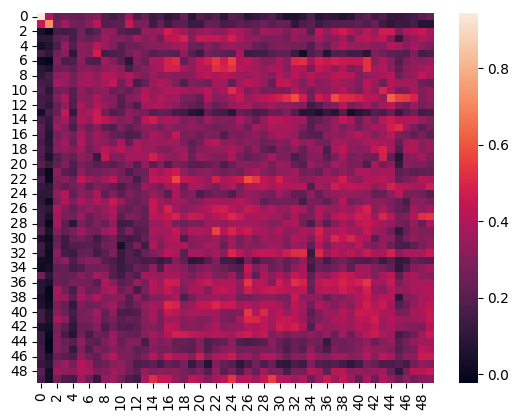

In [20]:
# heatmap
import seaborn as sns
sns.heatmap(cs_matrix)


## Full data

In [21]:
eng_full_embs = model.encode(englist)

In [22]:
print(eng_full_embs.__class__)
print(eng_full_embs.shape)

<class 'numpy.ndarray'>
(177, 768)


In [23]:
fi_full_embs = model.encode(filist)

In [24]:
print(fi_full_embs.__class__)
print(fi_full_embs.shape)

<class 'numpy.ndarray'>
(1356, 768)


In [27]:
# cosine similarity
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
from sklearn.metrics.pairwise import cosine_similarity as cs
cs_matrix = cs(fi_full_embs,eng_full_embs)

<Axes: >

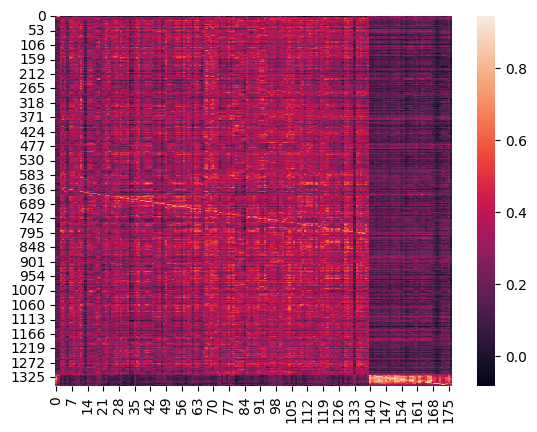

In [28]:
# heatmap
import seaborn as sns
sns.heatmap(cs_matrix)
